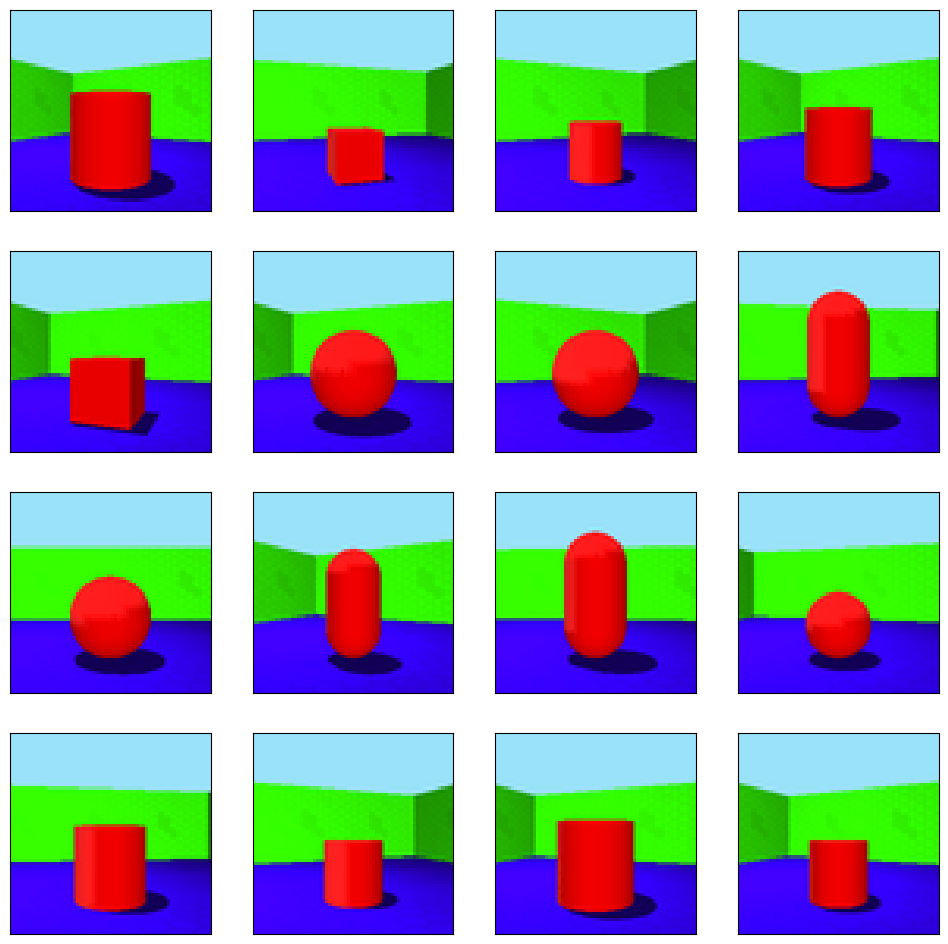

In [1]:
# Load python modules
import numpy as np, cv2, sys
from tqdm import tqdm
from matplotlib import pyplot as plt
np.set_printoptions(suppress=True)
# Load filtered image and label data sampled from 3dshapes_filtered.ipynb
images = np.load("3dshapesfiltered.npy")
labels = np.load("3dshapeslabel.npy")
# Define visualisation function from https://github.com/google-deepmind/3d-shapes
def show_images_grid(images, num_samples, num_images=25, random=False):
    ncols = int(np.ceil(num_images**0.5))
    nrows = int(np.ceil(num_images / ncols))
    _, axes = plt.subplots(ncols, nrows, figsize=(nrows*3, ncols*3))
    axes = axes.flatten()
    for ax_i, ax in enumerate(axes):
        if ax_i < num_images:
            if random:
                ax_i = np.random.choice(num_samples, 1)
            ax.imshow(images[int(ax_i[0])]/255.0, cmap='Greys_r', interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')
# Sanity check loaded images
show_images_grid(images*255.0, num_samples=480, num_images=16, random=True)

Step 1: Process training data such that floor/wall/object saturations are equal on the region of $\left[\epsilon, 0.5\right]$.

100%|██████████| 480/480 [00:33<00:00, 14.33it/s]


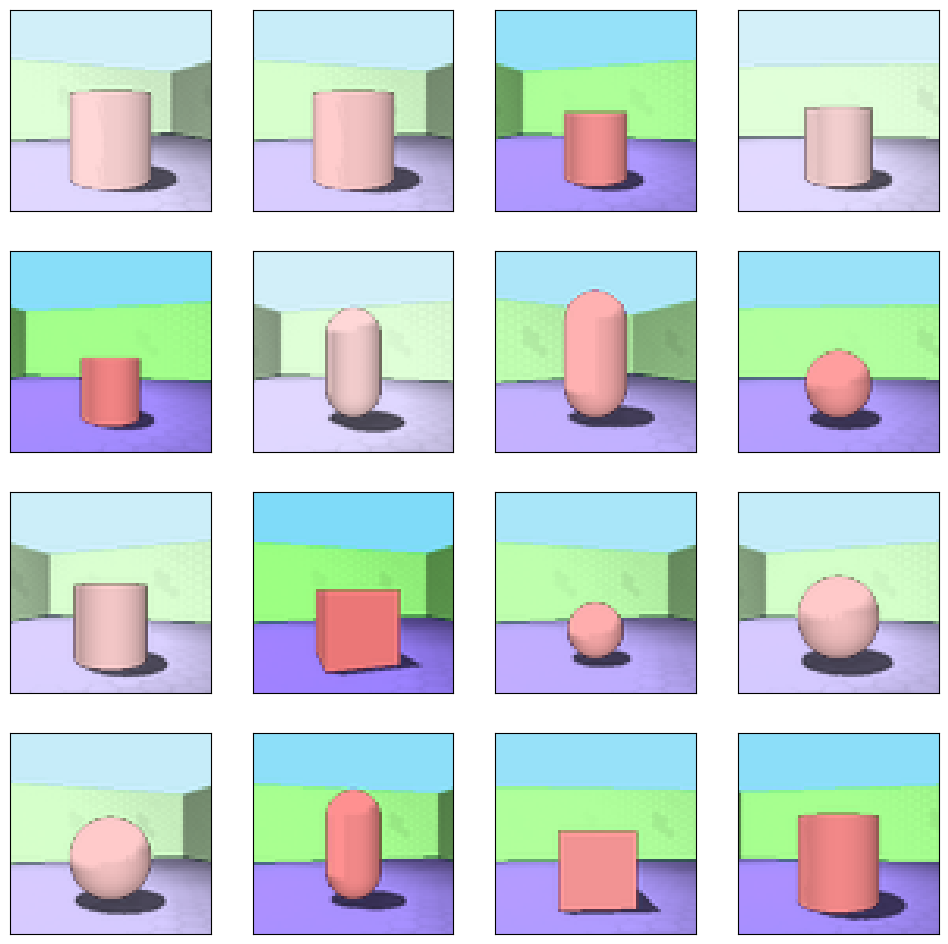

In [2]:
# Initialise number of base images
num_bases = len(images)
# Initialise fragmentation of saturation shift
num_shift = 1000
# Training images and labels array
images_train = np.zeros(shape=(num_bases*num_shift, 64, 64, 3), dtype=np.float32)
labels_train = np.zeros(shape=num_bases*num_shift, dtype=np.float32)
# Lop over base images and shift saturation globally
for i in tqdm(range(num_bases)):
    for j in range(num_shift):
        # Load target image
        target_image = images[i, :, :, :]*255.0
        # Load target label
        target_label = labels[i]
        # Convert image from RGB color space to HSV color space
        target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2HSV)
        # Split HSV representation into HSV channels
        h, s, v = cv2.split(target_image)
        # Change value of saturation channel
        s[:, :] = 0.1 + 0.8/(2*(num_shift-1))*j
        # Merge HSV back into target image
        target_image = cv2.merge([h, s, v])
        # Convert image from HSV color space to RGB color space
        target_image = cv2.cvtColor(target_image, cv2.COLOR_HSV2BGR)
        # Save saturation shifted image
        images_train[i*num_shift+j, :, :, :] = target_image
        # Save saturation shifted label
        labels_train[i*num_shift+j] = target_label
# Visualise saturation shifted images
show_images_grid(images_train, num_samples=num_bases*num_shift, num_images=16, random=True)
# Save training data
np.savez("3dshapes_satshifted_train.npz", images=images_train, labels=labels_train)

Step 2: Process testing data 1 such that floor/wall/object saturations are equal on the region of $\left(0.5, 1.0-\epsilon\right]$.

Test set 1 is for global saturation test.

100%|██████████| 480/480 [00:31<00:00, 15.00it/s]


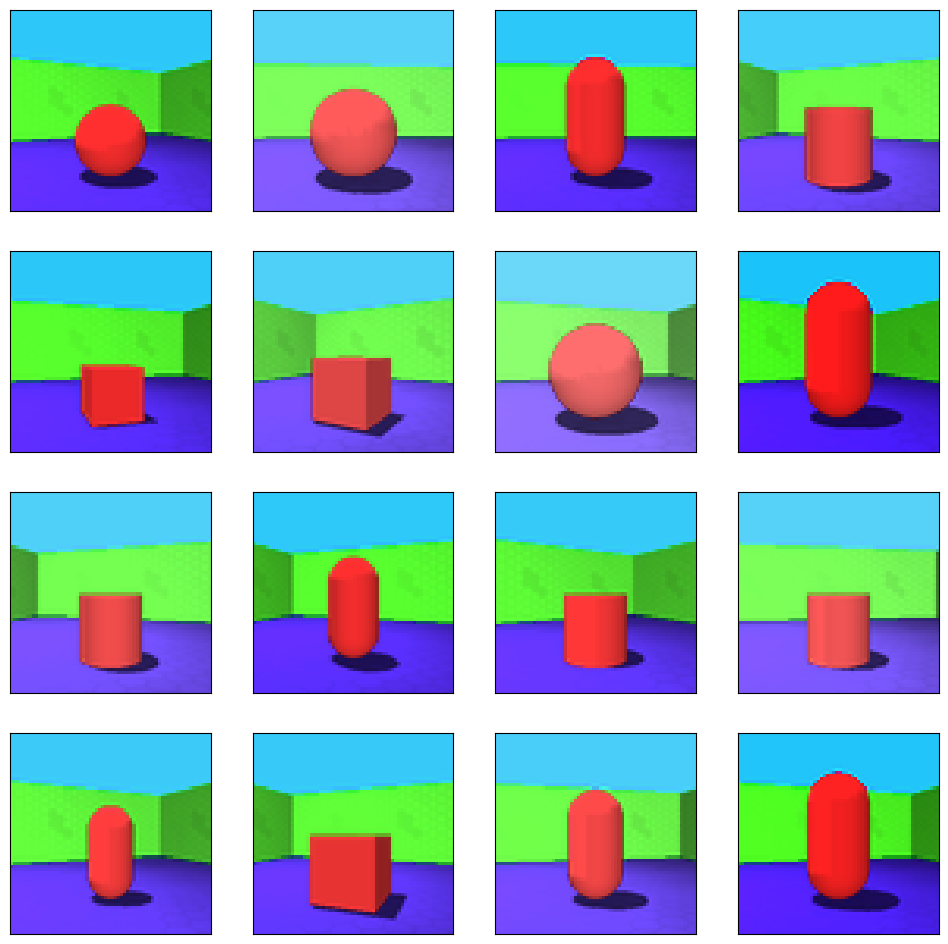

In [4]:
# Initialise number of base images
num_bases = len(images)
# Initialise fragmentation of saturation shift
num_shift = 1000
# Training images and labels array
images_test_1 = np.zeros(shape=(num_bases*num_shift, 64, 64, 3), dtype=np.float32)
labels_test_1 = np.zeros(shape=num_bases*num_shift, dtype=np.float32)
# Lop over base images and shift saturation globally
for i in tqdm(range(num_bases)):
    for j in range(num_shift):
        # Load target image
        target_image = images[i, :, :, :]*255.0
        # Load target label
        target_label = labels[i]
        # Convert image from RGB color space to HSV color space
        target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2HSV)
        # Split HSV representation into HSV channels
        h, s, v = cv2.split(target_image)
        # Change value of saturation channel
        s[:, :] = 0.5 + 0.8/(2*(num_shift-1))*j
        # Merge HSV back into target image
        target_image = cv2.merge([h, s, v])
        # Convert image from HSV color space to RGB color space
        target_image = cv2.cvtColor(target_image, cv2.COLOR_HSV2BGR)
        # Save saturation shifted image
        images_test_1[i*num_shift+j, :, :, :] = target_image
        # Save saturation shifted label
        labels_test_1[i*num_shift+j] = target_label
# Visualise saturation shifted images
show_images_grid(images_test_1, num_samples=num_bases*num_shift, num_images=16, random=True)
# Save training data
np.savez("3dshapes_satshifted_test_1.npz", images=images_test_1, labels=labels_test_1)

Step 3: Process testing data 1 such that floor/wall saturations are equal on the region of $\left[\epsilon, 0.5\right]$ and object saturation on the region of $\left(0.5, 1.0-\epsilon\right]$.

Test set 2 is for local saturation test.

100%|██████████| 480/480 [00:44<00:00, 10.78it/s]


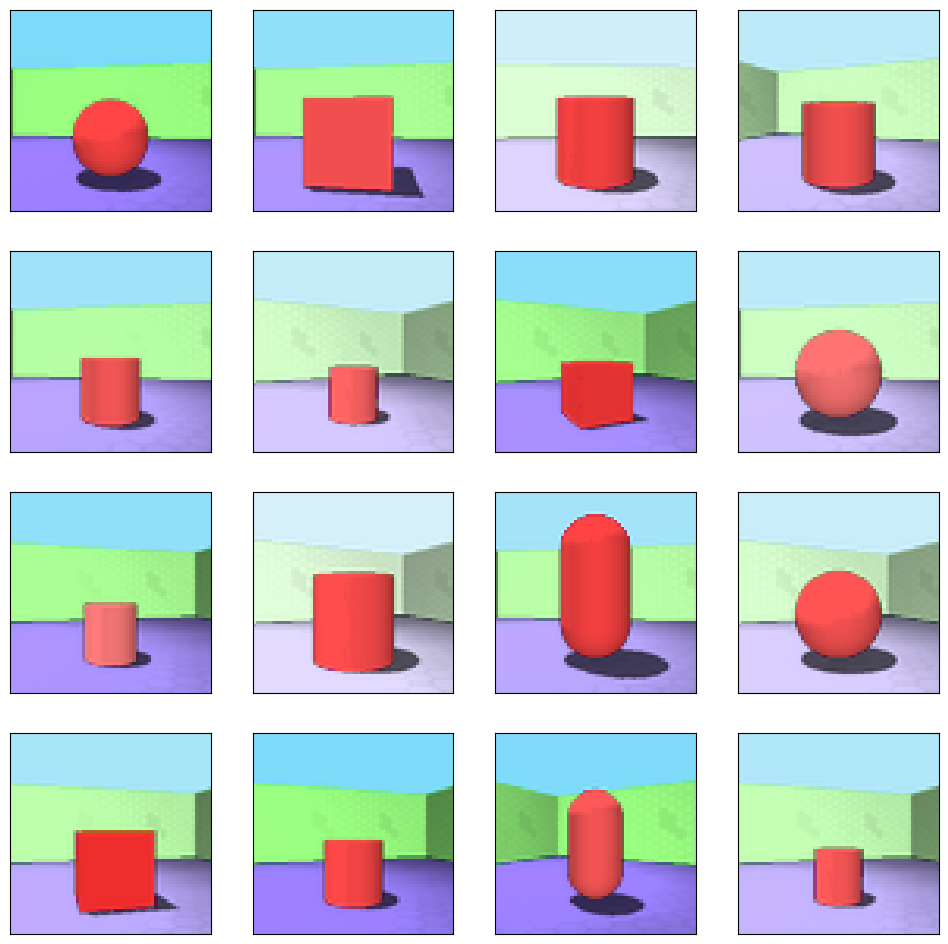

In [4]:
# Initialise number of base images
num_bases = len(images)
# Initialise fragmentation of saturation shift
num_shift = 1000
# Training images and labels array
images_test_2 = np.zeros(shape=(num_bases*num_shift, 64, 64, 3), dtype=np.float32)
labels_test_2 = np.zeros(shape=num_bases*num_shift, dtype=np.float32)
# Lop over base images and shift saturation locally on the object
for i in tqdm(range(num_bases)):
    for j in range(num_shift):
        # Load target image
        target_image = images[i, :, :, :]*255.0
        # Load target label
        target_label = labels[i]
        # Convert image from RGB color space to HSV color space
        target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2HSV)
        # Set upper and lower bound on hue for masking
        hue_lower, hue_upper = np.array([210, 0, 0]), np.array([280, 255, 255])
        # Create mask on object
        mask = cv2.inRange(target_image, hue_lower, hue_upper)
        # Split HSV representation into HSV channels
        h, s, v = cv2.split(target_image)
        # Change value of saturation channel for object
        s[mask==255] = 0.5 + np.random.uniform(low=0.0, high=0.4)
        # Change value of saturation channel for floor and wall
        s[mask==0] = 0.1 + np.random.uniform(low=0.0, high=0.4)
        # Merge HSV back into target image
        target_image = cv2.merge([h, s, v])
        # Convert image from HSV color space to RGB color space
        target_image = cv2.cvtColor(target_image, cv2.COLOR_HSV2BGR)
        # Save saturation shifted image
        images_test_2[i*num_shift+j, :, :, :] = target_image
        # Save saturation shifted label
        labels_test_2[i*num_shift+j] = target_label
# Visualise saturation shifted images
show_images_grid(images_test_2, num_samples=num_bases*num_shift, num_images=16, random=True)
# Save training data
np.savez("3dshapes_satshifted_test_2.npz", images=images_test_2, labels=labels_test_2)